In [17]:
import pandas as pd
from os.path import dirname, realpath, join, isfile
from urlparse import urlparse
from nb_utils import (get_ps1_or_ipaddress, read_pcap_fields_from_txts,
                   download_roku_channel_details, ROKU_MACS)

In [2]:
import seaborn as sns
%matplotlib inline
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(16,9)})

In [3]:
ROOT_PROJ_DIR = dirname(dirname(dirname(dirname(realpath('__file__')))))
DATA_DIR = join(ROOT_PROJ_DIR, "data/pcap_analysis/roku-channel-surfer/2018-09-27")
HTTP_REQS_DIR = join(DATA_DIR, "http")
DNS_QUERIES_DIR = join(DATA_DIR, "dns")
HTTP_CSV = join(DATA_DIR, "roku-2019-02-04-requests.csv")

### Load channel details
- We only channels details to add helper columns to request dataframe
- Once we build and store the request details, we don't actually need to do this

In [4]:
channel_df = download_roku_channel_details()
channel_df.head()

,_category,_scrape_ts,accessCode,desc,name,payment,price,rankByWatched,rating,thumbnail
id,,,,,,,,,,
12,movies-tvs,1537037970,101D4DEA,Watch TV shows and movies recommended just for...,Netflix,None,0,1,75.890121,http://channels.roku.com/images/f5e60d25f2c944...
2285,movies-tvs,1537037970,hulu,Stream all your TV in one place with Hulu. Get...,Hulu,None,0,3,74.931961,https://image.roku.com/developer_channels/prod...
13,movies-tvs,1537037970,8C42649C,Prime members can watch thousands of movies an...,Prime Video,None,0,4,73.552605,https://image.roku.com/developer_channels/prod...
46041,movies-tvs,1537037970,SlingTV,"Sling TV is Live TV, Only Better. The #1 Live ...",Sling TV,None,0,5,68.119362,https://image.roku.com/developer_channels/prod...
23048,movies-tvs,1537037970,twctv,"With Spectrum TV, you can enjoy up to 250 live...",Spectrum TV,None,0,6,64.740654,https://image.roku.com/developer_channels/prod...


## Load HTTP request details
- Load the request details from the CSV or build from scratch

In [18]:
if isfile(HTTP_CSV):
    # load from csv if we already built the dataframe
    df = pd.read_csv(HTTP_CSV, sep='\t', encoding='utf-8')
else:
    # we use `extract_fields.sh` script to extract the following fields:
    # 'eth_src', 'ip_dst', 'req_method', 'url' into separate text files
    # here we read the extracted fields into a dataframe
    http_fields = [req_fields for req_fields in read_pcap_fields_from_txts(HTTP_REQS_DIR)]
    df = pd.DataFrame(http_fields, columns=['channel_id', 'start_ts', 'command', 'select_idx', 'eth_src', 'ip_dst', 'req_method', 'url'])
    # we have some packets from the RPi's, filter them out
    df = df[df.eth_src.isin(ROKU_MACS)]
    df['channel_name'] = df['channel_id'].map(lambda x: channel_df.loc[int(x)]['name'])
    df['domain'] = df['url'].map(lambda x: get_ps1_or_ipaddress(x))
    df['host'] = df['url'].map(lambda x: urlparse(x).hostname)
    df['rank'] = df['channel_id'].map(lambda x: channel_df.loc[int(x)]['rankByWatched'])
    df['category'] = df['channel_id'].map(lambda x: channel_df.loc[int(x)]['_category'])
    df.to_csv(HTTP_CSV, index=False, sep='\t', encoding='utf-8')

In [19]:
df.head()

,channel_id,start_ts,command,select_idx,eth_src,ip_dst,req_method,url,channel_name,domain,host,rank,category
0,63344,1538096403,select,1,d8:31:34:22:e6:ff,23.33.105.154,GET,http://api.playplex.viacom.com/feeds/networkap...,Comedy Central,viacom.com,api.playplex.viacom.com,77,movies-tvs
1,63344,1538096403,select,1,d8:31:34:22:e6:ff,23.33.105.154,GET,http://api.playplex.viacom.com/feeds/networkap...,Comedy Central,viacom.com,api.playplex.viacom.com,77,movies-tvs
2,63344,1538096403,select,1,d8:31:34:22:e6:ff,173.222.212.76,GET,http://comedycentral.mtvnimages.com/uri/mgid:a...,Comedy Central,mtvnimages.com,comedycentral.mtvnimages.com,77,movies-tvs
3,63344,1538096403,select,1,d8:31:34:22:e6:ff,23.33.105.154,GET,http://api.playplex.viacom.com/feeds/networkap...,Comedy Central,viacom.com,api.playplex.viacom.com,77,movies-tvs
4,63344,1538096403,select,1,d8:31:34:22:e6:ff,23.33.105.154,GET,http://api.playplex.viacom.com/feeds/networkap...,Comedy Central,viacom.com,api.playplex.viacom.com,77,movies-tvs


### HTTP requests - overview

In [22]:
print "%d requests to %d distinct domains %d distinct hosts from %s distinct channels" %\
    (len(df), df.domain.nunique(), df.host.nunique(), df.channel_id.nunique())

30029 requests to 506 distinct domains 810 distinct hosts from 993 distinct channels


### Top domains
- domains contacted by most channels

In [23]:
df.drop_duplicates(subset=["channel_id", "domain"]).\
    groupby(["domain"]).size().reset_index(name="# channels").\
    sort_values(by=['# channels'], ascending=False).head(10)

,domain,# channels
227,ifood.tv,329
243,irchan.com,183
368,scorecardresearch.com,117
501,yumenetworks.com,114
152,doubleclick.net,106
208,google-analytics.com,101
389,spotxchange.com,75
141,demdex.net,70
170,exelator.com,57
108,crwdcntrl.net,55


### Top domains - Kids and family channels

In [24]:
df[df.category == "kids-family"].drop_duplicates(subset=["channel_id", "domain"]).\
    groupby(["domain"]).size().reset_index(name="# channels").\
    sort_values(by=['# channels'], ascending=False).head(10)

,domain,# channels
44,ifood.tv,272
85,spotxchange.com,51
102,yumenetworks.com,39
80,scorecardresearch.com,30
29,doubleclick.net,23
50,irchan.com,21
36,google-analytics.com,20
27,demdex.net,14
11,agkn.com,13
22,crwdcntrl.net,13


### Channels contacting the most domains

In [25]:
df_n_domains_by_channel = df.drop_duplicates(subset=["channel_name", "domain", "rank"]).\
    groupby(["channel_name", "rank"]).size().reset_index(name="# domains").\
    sort_values(by=['# domains'], ascending=False)
df_n_domains_by_channel.head(10)

,channel_name,rank,# domains
8,8ctave HD,936,56
940,WatchFreeForeignFlix,1100,39
415,Horror Films by Fawesome.tv,983,33
467,KMTV - Watch K-Pop,2185,32
939,WatchFreeFlix,81,32
937,WatchFreeActionThrillerFlix,738,32
49,AsianCrush,277,31
938,WatchFreeDocumentaryFlix,990,29
569,Midnight Pulp,315,28
588,Movee4U Free,680,17


### Kids and family channels contacting the most domains

In [26]:
df_n_domains_by_kids_channel = df[df.category == "kids-family"].drop_duplicates(subset=["channel_name", "domain", "rank"]).\
    groupby(["channel_name", "rank"]).size().reset_index(name="# domains").\
    sort_values(by=['# domains'], ascending=False)
df_n_domains_by_kids_channel.head(10)

,channel_name,rank,# domains
277,Popcornflix Kids,268,12
346,Toontime TV,1641,11
343,Toontime 2,2170,11
307,Superman 3D,1708,11
123,Funny Cartoon Club,2490,10
53,Cartoon Club,1637,9
178,Kiddovid,3168,9
58,Cartoon Station,1744,9
68,Classic Cartoon Channel,1448,9
81,Comic Animations,2457,9


### Effect of popularity (rank)
- Do popular channels contact more domains?

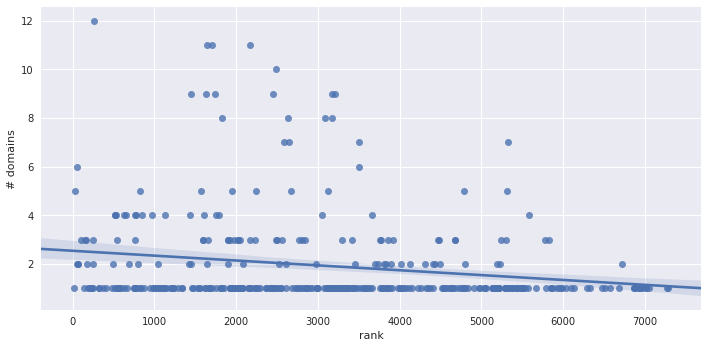

In [27]:
sns.lmplot(x="rank", y="# domains", data=df_n_domains_by_kids_channel, size=5, aspect=2)

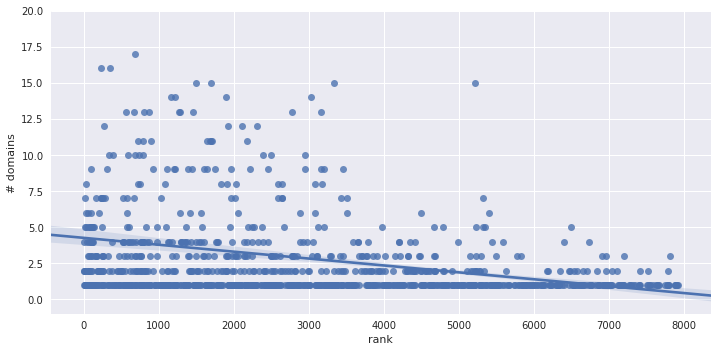

In [28]:
ax = sns.lmplot(x="rank", y="# domains", data=df_n_domains_by_channel, size=5, aspect=2)
ax.set(ylim=(-1, 20))

### TODOs
- what are the domains that are TV/OTT only (e.g. checking on the HTTPArchive data`spotxchange.com` domain is never seen on the web)
- we don't include channels with zero HTTP requests into this analysis (i.e. the above plots need to be redrawn)

In [29]:
df.sort_values("rank", inplace=True)
df[df.url.str.contains("doubleclick")]

,channel_id,start_ts,command,select_idx,eth_src,ip_dst,req_method,url,channel_name,domain,host,rank,category
6148,41468,1538090032,select,1,d8:31:34:22:e6:ff,216.58.219.194,GET,http://cm.g.doubleclick.net/pixel?google_nid=x...,Tubi,doubleclick.net,cm.g.doubleclick.net,20,movies-tvs
6147,41468,1538090032,select,1,d8:31:34:22:e6:ff,216.58.219.194,GET,http://cm.g.doubleclick.net/pixel?google_nid=x...,Tubi,doubleclick.net,cm.g.doubleclick.net,20,movies-tvs
4248,38896,1538096952,select,0,d8:31:34:22:e6:ff,172.217.11.2,GET,http://cm.g.doubleclick.net/pixel?google_nid=p...,WatchFreeFlix,doubleclick.net,cm.g.doubleclick.net,81,movies-tvs
4254,38896,1538096952,select,0,d8:31:34:22:e6:ff,172.217.11.2,GET,http://cm.g.doubleclick.net/pixel?cb=http%3A%2...,WatchFreeFlix,doubleclick.net,cm.g.doubleclick.net,81,movies-tvs
4255,38896,1538096952,select,0,d8:31:34:22:e6:ff,172.217.11.2,GET,http://cm.g.doubleclick.net/pixel?cb=http%3A%2...,WatchFreeFlix,doubleclick.net,cm.g.doubleclick.net,81,movies-tvs
4259,38896,1538096952,select,0,d8:31:34:22:e6:ff,172.217.11.2,GET,http://cm.g.doubleclick.net/pixel?cb=http%3A%2...,WatchFreeFlix,doubleclick.net,cm.g.doubleclick.net,81,movies-tvs
4260,38896,1538096952,select,0,d8:31:34:22:e6:ff,172.217.11.2,GET,http://cm.g.doubleclick.net/pixel?cb=http%3A%2...,WatchFreeFlix,doubleclick.net,cm.g.doubleclick.net,81,movies-tvs
21156,6119,1538099035,select,2,d8:31:34:22:e6:ff,172.217.10.130,GET,http://pubads.g.doubleclick.net/pagead/convers...,Popcornflix,doubleclick.net,pubads.g.doubleclick.net,94,movies-tvs
21152,6119,1538099035,select,2,d8:31:34:22:e6:ff,172.217.10.130,GET,http://pubads.g.doubleclick.net/pagead/convers...,Popcornflix,doubleclick.net,pubads.g.doubleclick.net,94,movies-tvs
21158,6119,1538099035,select,2,d8:31:34:22:e6:ff,172.217.10.130,GET,http://pubads.g.doubleclick.net/pagead/convers...,Popcornflix,doubleclick.net,pubads.g.doubleclick.net,94,movies-tvs
